In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
digits = load_digits()
X = digits.data
y = digits.target

In [3]:
num_col = X.shape[1]
digits_df = pd.DataFrame()

for col in range(num_col):
    digits_df[f'X{col}'] = X[:,col] # Loop through each column and add it to the DataFrame
    

digits_df['target'] = y

digits_df.head(10)

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X55,X56,X57,X58,X59,X60,X61,X62,X63,target
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4
5,0.0,0.0,12.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,9.0,16.0,16.0,10.0,0.0,0.0,5
6,0.0,0.0,0.0,12.0,13.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,9.0,15.0,11.0,3.0,0.0,6
7,0.0,0.0,7.0,8.0,13.0,16.0,15.0,1.0,0.0,0.0,...,0.0,0.0,0.0,13.0,5.0,0.0,0.0,0.0,0.0,7
8,0.0,0.0,9.0,14.0,8.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,11.0,16.0,15.0,11.0,1.0,0.0,8
9,0.0,0.0,11.0,12.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,9.0,12.0,13.0,3.0,0.0,0.0,9


# Set up test and training sets

In [4]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Convert to tensors

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

X_train_tensor = torch.tensor(X_train, dtype= torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype= torch.float32).to(device)
y_train_tensor = torch.tensor(y_train,dtype=torch.int64).to(device)
y_test_tensor = torch.tensor(y_test,dtype=torch.int64).to(device)

 # Create Classifier Class

In [6]:
class SimpleClassifier(nn.Module):
    def __init__(self,in_features, out_features):
        super().__init__()
        self.layer1 = nn.Linear(in_features,256)
        self.layer2 = nn.Linear(256,128)
        self.layer3 = nn.Linear(128,64)
        self.layer4 = nn.Linear(64,out_features)

    def forward(self,x):
        x = torch.relu(self.layer4(self.layer3(self.layer2(self.layer1(x)))))
        return x
    

in_features = X_train.shape[1] #number of X features
out_features = len(set(y)) #number of outputs with duplicates removed

print(f'in features: {in_features}, out features: {out_features}')

model = SimpleClassifier(in_features,out_features).to(device)


in features: 64, out features: 10


# Create Training Loop

In [7]:
criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(model.parameters(), lr = 0.05)


num_epochs = 100

for epoch in range(num_epochs):
    #run forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs,y_train_tensor)


    _, predicted_labels = torch.max(outputs,1)

    
    # Calculate the number of correct predictions by comparing predicted labels with actual labels
    correct_predictions = (predicted_labels == y_train_tensor).sum().item()


    # Calculate total number of samples and accuracy as the ratio of correct predictions to total samples
    total_samples = len(y_train_tensor)
    acc = correct_predictions / total_samples

    #do backward pass
    optimiser.zero_grad() #clears all gradients to start the next gradient decent on next epoch
    loss.backward() #performs backwards pass
    optimiser.step() # Update the model parameters using the computed gradients (based on the optimization algorithm, e.g., SGD)

    #print the loss and accuracy every 10 epochs

    if(epoch + 1)%10 ==0:
        print(f'epoch [{epoch+1}/{num_epochs}], loss : {loss.item(): .4f}, accuracy: {acc: .4f}')

epoch [10/100], loss :  2.1698, accuracy:  0.4475
epoch [20/100], loss :  1.9666, accuracy:  0.6061
epoch [30/100], loss :  1.6965, accuracy:  0.7029
epoch [40/100], loss :  1.3773, accuracy:  0.7815
epoch [50/100], loss :  1.0808, accuracy:  0.8038
epoch [60/100], loss :  0.8711, accuracy:  0.8205
epoch [70/100], loss :  0.7327, accuracy:  0.8330
epoch [80/100], loss :  0.6333, accuracy:  0.8413
epoch [90/100], loss :  0.5519, accuracy:  0.8532
epoch [100/100], loss :  0.4799, accuracy:  0.8699


# Evaluate with test data

In [8]:
model.eval()
with torch.inference_mode():
    # Pass the test data through the model to get output predictions (logits)
    outputs = model(X_test_tensor)

    # Find the predicted class labels by taking the index of the maximum value along dimension 1

    _, predicted = torch.max(outputs,1)

    accuracy = accuracy_score(y_test,predicted.cpu().numpy())

     # Create a copy of the predicted tensor, detached from the computation graph
    # This ensures the tensor is independent and doesn't track gradients

    predicted_tensor = predicted.clone().detach()

    loss = criterion(outputs,predicted_tensor)

    print(f'loss: {loss.item(): .4f}, accuracy: {accuracy: .4f}')

loss:  0.3149, accuracy:  0.8722


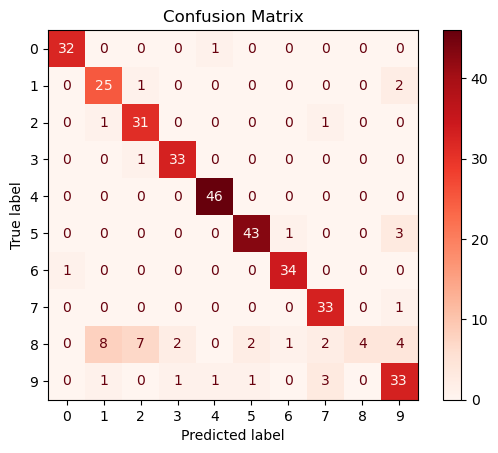

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

num_classes = out_features

# Evaluate using test set
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    
    # Convert tensors to numpy arrays
    y_test_np = y_test_tensor.cpu().numpy()
    predicted_np = predicted.cpu().numpy()
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test_np, predicted_np, labels=np.arange(num_classes))
    
    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=digits.target_names)
    disp.plot(cmap='Reds', values_format='d')
    plt.title('Confusion Matrix')
    plt.show()